# Jupiter Notebook to build a quick and imperfect prediction solution

This notebook is an attempt to train a model to predict the salary in Data Science based on the kaggle dataset from https://www.kaggle.com/datasets/lainguyn123/data-science-salary-landscape.

In [137]:
# Package for linear regressions


import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 

from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import r2_score,root_mean_squared_log_error
from sklearn.model_selection import train_test_split 
from sklearn.neighbors import KNeighborsRegressor
sns.set_theme()
import warnings
warnings.filterwarnings('ignore')

## Import the feature preparation script

We are going to import the feature preparation script and use it to prepare the features.

In [138]:
%load_ext autoreload
%autoreload 2



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [139]:
from ml import  FeaturePreprocessor
feature_preprocessor = FeaturePreprocessor()

Training categorical features...
   Loading model features...
Categorical features training done.


## Loading and Cleaning datasets

In this section, we will load the dataset and extract the features and performs the cleaning.

In [140]:
pd.options.display.float_format = '{:.2f}'.format

salaries_dataset_url = './ds_salaries.csv'
full_dataset = pd.read_csv(salaries_dataset_url)
full_dataset.describe(include='all').T



,count,unique,top,freq,mean,std,min,25%,50%,75%,max
work_year,3755.00,NaN,NaN,NaN,2022.37,0.69,2020.00,2022.00,2022.00,2023.00,2023.00
experience_level,3755,4,SE,2516,NaN,NaN,NaN,NaN,NaN,NaN,NaN
employment_type,3755,4,FT,3718,NaN,NaN,NaN,NaN,NaN,NaN,NaN
job_title,3755,93,Data Engineer,1040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salary,3755.00,NaN,NaN,NaN,190695.57,671676.50,6000.00,100000.00,138000.00,180000.00,30400000.00
salary_currency,3755,20,USD,3224,NaN,NaN,NaN,NaN,NaN,NaN,NaN
salary_in_usd,3755.00,NaN,NaN,NaN,137570.39,63055.63,5132.00,95000.00,135000.00,175000.00,450000.00
employee_residence,3755,78,US,3004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
remote_ratio,3755.00,NaN,NaN,NaN,46.27,48.59,0.00,0.00,0.00,100.00,100.00
company_location,3755,72,US,3040,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [141]:

X,Y = feature_preprocessor.transform_df(full_dataset)

# We apply log on the salary feature
X.info()
Y.info()
feature_cols = X.columns

print("Features num=", len(feature_cols), feature_cols)
# Export CSV
X.to_csv('train.csv', index=False)  

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, random_state=42)


<class 'pandas.core.frame.DataFrame'>
Index: 3678 entries, 0 to 3754
Columns: 237 entries, remote_ratio to company_size_S
dtypes: float64(58), int64(179)
memory usage: 6.7 MB
<class 'pandas.core.series.Series'>
Index: 3678 entries, 0 to 3754
Series name: salary_in_usd
Non-Null Count  Dtype  
--------------  -----  
3678 non-null   float64
dtypes: float64(1)
memory usage: 57.5 KB
Features num= 237 Index(['remote_ratio', '3d', 'ai', 'analyst', 'analytics', 'applied',
       'architect', 'autonomous', 'azure', 'bi',
       ...
       'company_location_SG', 'company_location_SI', 'company_location_SK',
       'company_location_TH', 'company_location_TR', 'company_location_UA',
       'company_location_US', 'company_location_VN', 'company_size_M',
       'company_size_S'],
      dtype='object', length=237)


### Split the dataset in train and test



In [142]:
print("X_train", X_train.shape)
print("X_test", X_test.shape)
print("Y_train", y_train.shape)
print("Y_test", y_test.shape)

X_train (3310, 237)
X_test (368, 237)
Y_train (3310,)
Y_test (368,)


## Model training

We will use a hierarchical model to train.

In [143]:
from lightgbm import LGBMRegressor
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.discriminant_analysis import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import ARDRegression, BayesianRidge, HuberRegressor, Lars, LarsCV, Lasso, LassoCV, LogisticRegression, MultiTaskElasticNet, QuantileRegressor, RANSACRegressor, RidgeCV, SGDRegressor, TheilSenRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
import tensorflow as tf
from xgboost import XGBRegressor


def get_estimators(X, y):
    cat_selector = make_column_selector(dtype_include=object)
    num_selector = make_column_selector(dtype_include=np.number)
    cat_selector(X)


    cat_tree_processor = OrdinalEncoder(
        handle_unknown="use_encoded_value",
        unknown_value=-1,
        encoded_missing_value=-2,
    )
    num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

    cat_linear_processor = OneHotEncoder(handle_unknown="ignore")
    num_linear_processor = make_pipeline(
        StandardScaler(), 
        SimpleImputer(strategy="mean", add_indicator=True)
    )

    linear_preprocessor = make_column_transformer(
        (num_linear_processor, num_selector), 
        (cat_linear_processor, cat_selector)
    )

    tree_preprocessor = make_column_transformer(
        (num_tree_processor, num_selector), (cat_tree_processor, cat_selector)
    )

    rf_pipeline = make_pipeline(tree_preprocessor, RandomForestRegressor(random_state=42))
    
    knn_pipeline = make_pipeline(
        linear_preprocessor, KNeighborsRegressor(n_neighbors=8)
    )
    dt_params = {'max_depth': 100,'min_samples_split': 2, 'criterion': 'poisson'}
    gb_params = {'n_estimators': 500,
        'max_depth': 4,
        'min_samples_split': 5,
        'learning_rate': 0.01,
        'loss': 'squared_error'}
    estimators = [
        ("Random Forest", rf_pipeline),
        #("LassoCV", lasso_pipeline),
        #("Gradient Boosting", make_pipeline(linear_preprocessor, GradientBoostingRegressor(**gb_params))),
        ("KNN", knn_pipeline),   
        ("DecisionTreeRegressor", make_pipeline(tree_preprocessor, DecisionTreeRegressor(**dt_params))),
        #("ARDRegression", make_pipeline(linear_preprocessor, ARDRegression())),   
        #("HuberRegressor", make_pipeline(linear_preprocessor, HuberRegressor())),   
        #("LarsCV", make_pipeline(linear_preprocessor, LarsCV())),   
        #("QuantileRegressor", make_pipeline(linear_preprocessor, QuantileRegressor())),
        ("Bayesian", make_pipeline(linear_preprocessor, BayesianRidge())),
        #("LR", make_pipeline(linear_preprocessor, LinearRegression(positive=True))),   
        ("XGB", make_pipeline(linear_preprocessor, XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8))),   
        #("LGBM", make_pipeline(linear_preprocessor, LGBMRegressor(learning_rate=0.1))),   
        #("SVR", make_pipeline(linear_preprocessor, SVR())),   
        #('Ridge', make_pipeline(linear_preprocessor, Ridge(alpha=10))),
        #('ENet', make_pipeline(linear_preprocessor, ElasticNet(alpha=0.006974)))
    ]
    return estimators


estimators = get_estimators( X_train, y_train )

def predict_and_evaluate(model, X_test, y_test):
    y_pred = model.predict(X_test)

    #print("Predictions: ", y_pred[y_pred < 0])
    #print("Predictions2: ", y_test)
    #print(y_pred[0:5])
    #print(y_test[0:5])

    ## Compute Accuracy

    print("mean_squared_log_error (MSLE): %.2f" % mean_squared_log_error(y_test, y_pred))  
    print("root_mean_squared_log_error: %.2f" % root_mean_squared_log_error(y_test, y_pred))
    print("Coefficient of determination, R2: %.2f" % r2_score(y_test, y_pred))


for name, model in estimators:
    print(f"{name}: ")
    model.fit(X_train, y_train)         
    predict_and_evaluate(model, X_test, y_test)

print("--------------------------------")
print("Stacking regressor") 
regr = StackingRegressor(estimators=estimators, final_estimator=RidgeCV(),passthrough=True )
regr.fit(X_train, y_train)
predict_and_evaluate(regr, X_test, y_test)


Random Forest: 
mean_squared_log_error (MSLE): 0.00
root_mean_squared_log_error: 0.03
Coefficient of determination, R2: 0.56
KNN: 
mean_squared_log_error (MSLE): 0.00
root_mean_squared_log_error: 0.03
Coefficient of determination, R2: 0.46
DecisionTreeRegressor: 
mean_squared_log_error (MSLE): 0.00
root_mean_squared_log_error: 0.03
Coefficient of determination, R2: 0.48
Bayesian: 
mean_squared_log_error (MSLE): 0.00
root_mean_squared_log_error: 0.03
Coefficient of determination, R2: 0.55
XGB: 
mean_squared_log_error (MSLE): 0.00
root_mean_squared_log_error: 0.03
Coefficient of determination, R2: 0.59
--------------------------------
Stacking regressor
mean_squared_log_error (MSLE): 0.00
root_mean_squared_log_error: 0.03
Coefficient of determination, R2: 0.57


### Graph and precision evaluation

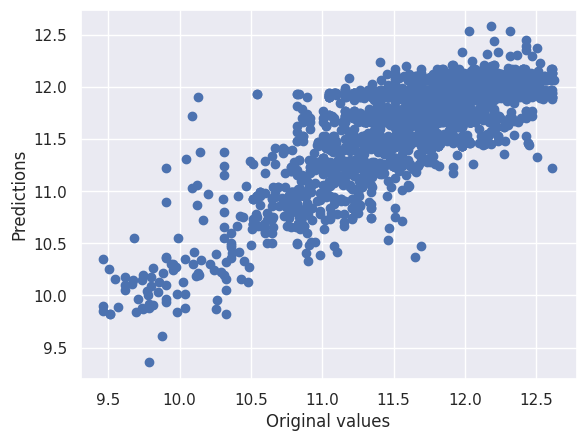

In [144]:
reg=LinearRegression(positive=True)
reg.fit(X_train, y_train)
yhat = reg.predict(X_train)
plt.scatter(y_train, yhat)
plt.xlabel('Original values')
plt.ylabel('Predictions')
plt.show()


In [145]:
linear_predictions = reg.predict(X_test)
our_mode_predictions = regr.predict(X_test)


print("root_mean_squared_log_error: LinearR %.2f" % root_mean_squared_log_error(y_test, linear_predictions))
print("root_mean_squared_log_error : our Model: %.2f" % root_mean_squared_log_error(y_test, our_mode_predictions))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination, LinearR, R2: %.2f" % r2_score(y_test, linear_predictions))
print("Coefficient of determination complex, our Model, R2: %.2f" % r2_score(y_test, our_mode_predictions))



results = pd.DataFrame({'Prediction': np.exp(linear_predictions), 'Actual': np.exp(y_test)})
results["Prediction my model"] = np.exp(our_mode_predictions)
results['Difference'] = np.exp(y_test) - np.exp(linear_predictions)
results['Difference %'] = abs(results['Difference'])/results['Actual']
results['Difference2'] = np.exp(y_test) - np.exp(our_mode_predictions)
results['Difference2 %'] = abs(results['Difference2'])/results['Actual']

results.sort_values(by='Difference %')

root_mean_squared_log_error: LinearR 0.03
root_mean_squared_log_error : our Model: 0.03
Coefficient of determination, LinearR, R2: 0.51
Coefficient of determination complex, our Model, R2: 0.57


,Prediction,Actual,Prediction my model,Difference,Difference %,Difference2,Difference2 %
2952,124328.02,124270.00,119289.00,-58.02,0.00,4981.00,0.04
30,72563.50,72000.00,133556.14,-563.50,0.01,-61556.14,0.85
485,153153.92,151800.00,149963.91,-1353.92,0.01,1836.09,0.01
1062,207861.13,205920.00,192541.83,-1941.13,0.01,13378.17,0.06
894,121211.08,120000.00,118980.19,-1211.08,0.01,1019.81,0.01
285,158194.62,160000.00,158090.43,1805.38,0.01,1909.57,0.01
1813,101144.09,100000.00,102871.34,-1144.09,0.01,-2871.34,0.03
357,158194.62,156000.00,159495.03,-2194.62,0.01,-3495.03,0.02
3294,152146.24,150000.00,152420.02,-2146.24,0.01,-2420.02,0.02
3427,73835.53,75000.00,142239.86,1164.47,0.02,-67239.86,0.90


## Export the model


We are going to save the model using joblib.

In [146]:
import joblib
regr.fit(X,Y)
joblib.dump(regr, 'model/salary_prediction_model.pkl')

['model/salary_prediction_model.pkl']

In [147]:
import json


column_list = X_train.columns.to_list()
# convert to Json
json_str = json.dumps(column_list)
# displaying
print("Json List:", json_str)

with open("model/model_features.json", "w") as final:
    json.dump({
        "columns": column_list,
        "nb_rows" : X_train.shape[0]
    }, final)




Json List: ["remote_ratio", "3d", "ai", "analyst", "analytics", "applied", "architect", "autonomous", "azure", "bi", "big", "business", "cloud", "compliance", "computer", "consultant", "data", "database", "deep", "developer", "devops", "director", "engineer", "etl", "finance", "financial", "head", "infrastructure", "insight", "intelligence", "lead", "learning", "machine", "management", "manager", "marketing", "ml", "mlops", "modeler", "nlp", "of", "operations", "power", "principal", "product", "programmer", "quality", "research", "researcher", "science", "scientist", "software", "specialist", "staff", "strategist", "tech", "technician", "vehicle", "vision", "work_year_2021", "work_year_2022", "work_year_2023", "experience_level_EX", "experience_level_MI", "experience_level_SE", "employment_type_FL", "employment_type_FT", "employment_type_PT", "salary_currency_BRL", "salary_currency_CAD", "salary_currency_CHF", "salary_currency_CLP", "salary_currency_CZK", "salary_currency_DKK", "salary

We need to save the list of feature columns because our future test data maz not have all the data

## We will generate two additional models to predict the lower and higher bounds for our confidence inte



In [148]:
from sklearn.ensemble import GradientBoostingRegressor# Set lower and upper quantile
LOWER_ALPHA = 0.1
UPPER_ALPHA = 0.9
# Each model has to be separate
lower_model = GradientBoostingRegressor(loss="quantile",                   
                                        alpha=LOWER_ALPHA)
upper_model = GradientBoostingRegressor(loss="quantile",
                                        alpha=UPPER_ALPHA)

# Fit models
lower_model.fit(X, Y)
upper_model.fit(X, Y) 

joblib.dump(lower_model, 'model/low_bound_model.pkl')
joblib.dump(upper_model, 'model/high_bound_model.pkl')


['model/high_bound_model.pkl']

In [149]:
#Try a simple prediction

from ml.salary_prediction_submission import SalaryPredictionSubmission
feature_preprocessor = FeaturePreprocessor()

example_value = SalaryPredictionSubmission(
    work_year="2024",
    job_title="Data Scientist",
    experience_level="EX",
    employment_type="FT", 
    remote_ratio= 100,
    employee_residence="US",
    company_location= "US", 
    company_size = "M"
)
example_df = feature_preprocessor.transform_input(example_value) 
result = regr.predict(example_df)
print(f"Result is {np.exp(result)}")

Training categorical features...
   Loading model features...
Categorical features training done.
Result is [186145.01738373]
